<a href="https://colab.research.google.com/github/vyjayanthik/Enhancing-road-safety-through-driver-inattention-detection/blob/main/Road_Safety.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CNN


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading and preparing data...
Training set shape: (11948, 128, 128, 3)
Validation set shape: (1922, 128, 128, 3)
Test set shape: (985, 128, 128, 3)

Creating and training model...
Epoch 1/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 26s 40ms/step - accuracy: 0.4460 - loss: 1.3878 - val_accuracy: 0.6041 - val_loss: 1.0623
Epoch 2/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6034 - loss: 1.0407 - val_accuracy: 0.7040 - val_loss: 0.8232
Epoch 3/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7066 - loss: 0.7972 - val_accuracy: 0.7638 - val_loss: 0.6807
Epoch 4/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7713 - loss: 0.6352 - val_accuracy: 0.8106 - val_loss: 0.5550
Epoch 5/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8028 - loss: 0.5402 - val_accuracy: 0.8424 - val_loss: 0.4600
Epoch 6/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8347 - loss: 0.4552 - val_accuracy: 0.8694 - val_loss: 0.4007
Epoch 7/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/ste

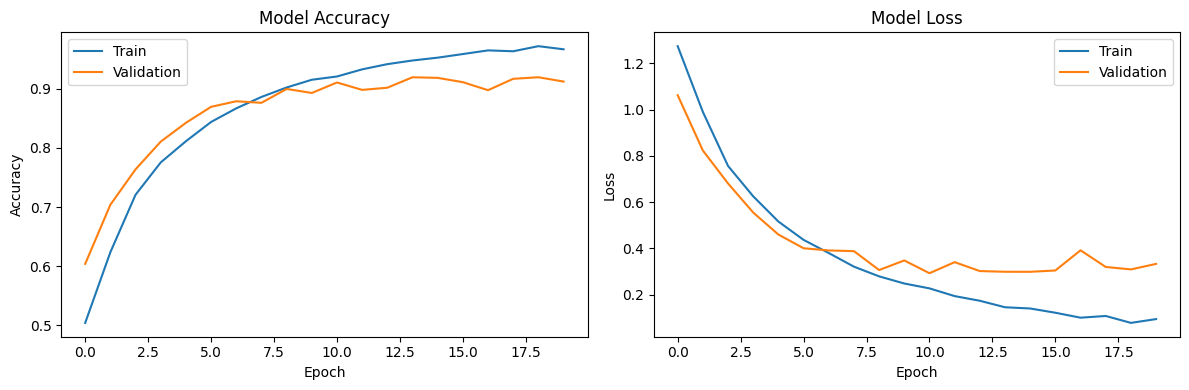


Evaluating model...
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9022 - loss: 0.3407
Test accuracy: 0.9036

Visualizing predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


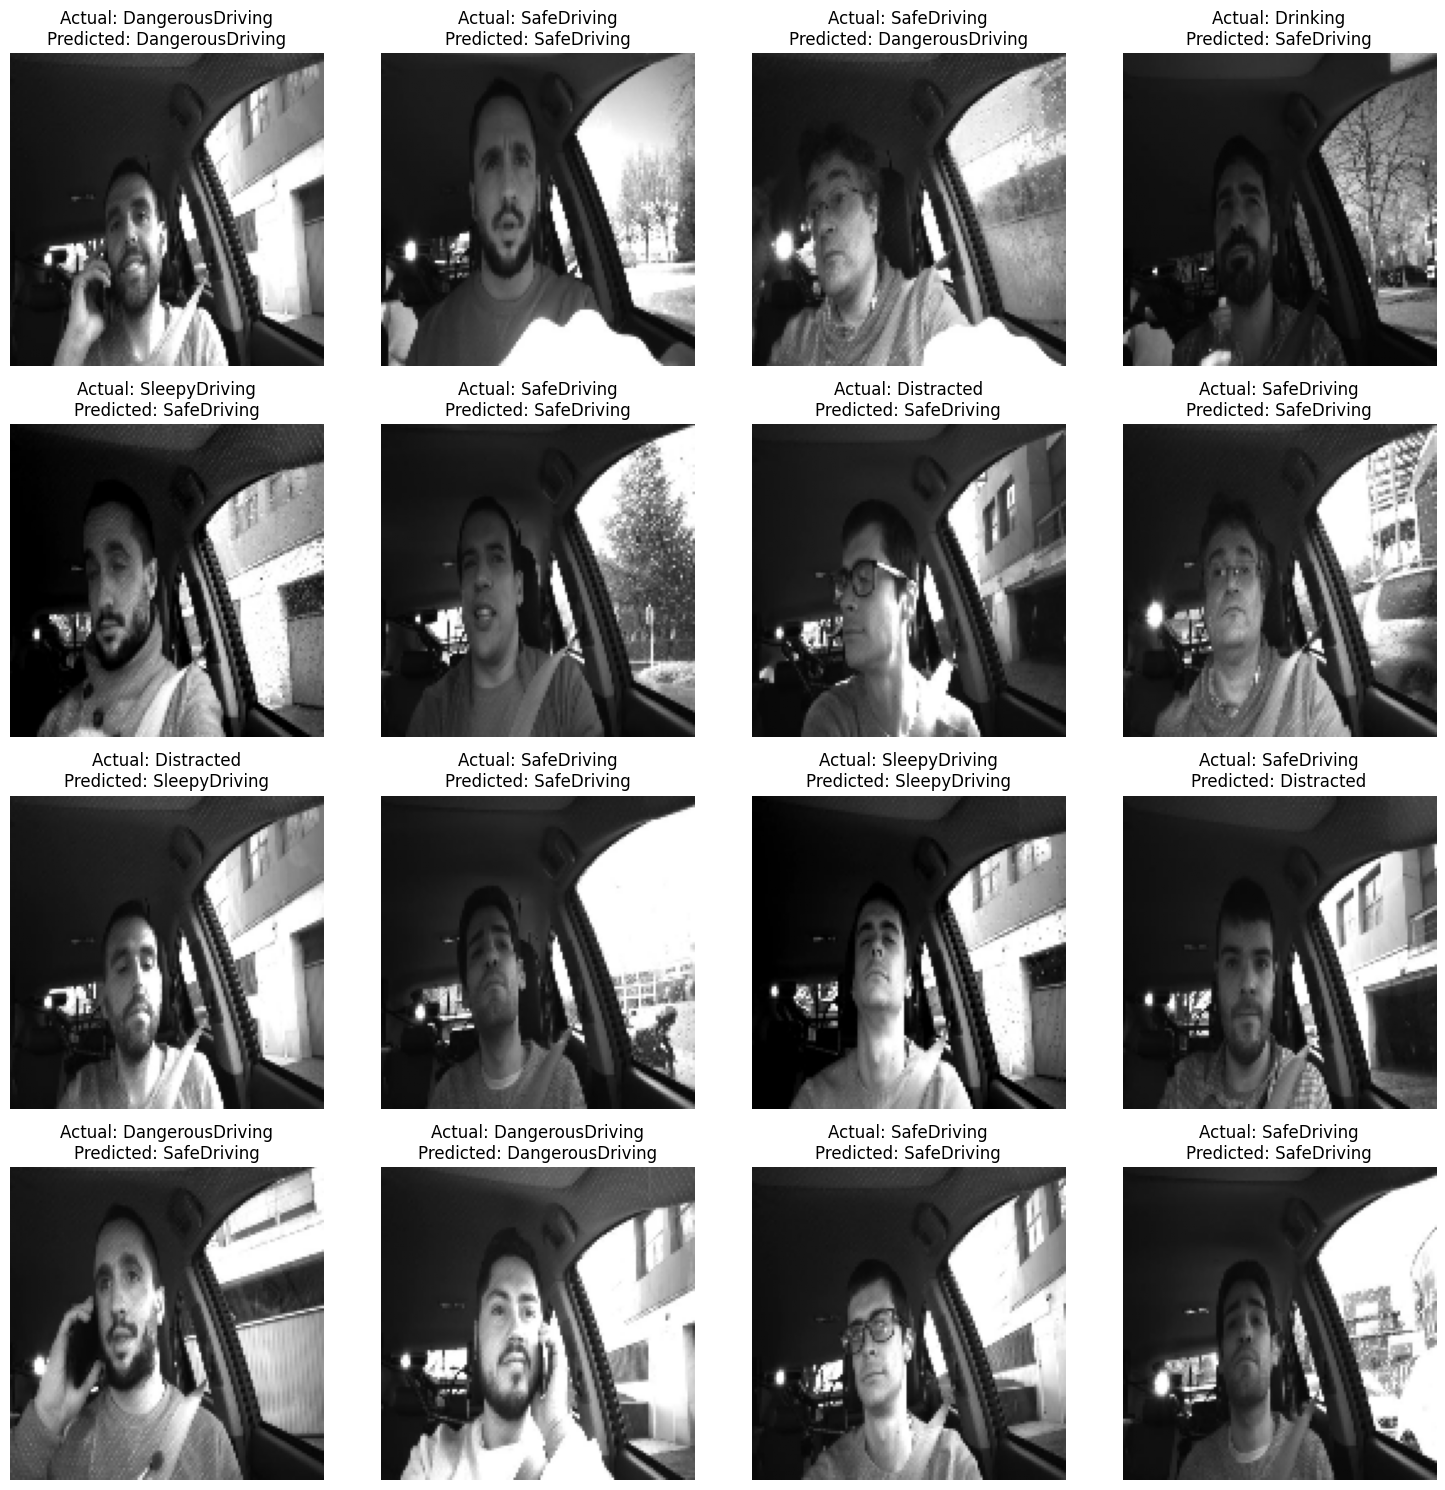


Saving model...

Model saved


In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Constants
TRAIN_PATH = '/content/drive/MyDrive/data/train'
TEST_PATH = '/content/drive/MyDrive/data/test'
VALID_PATH = '/content/drive/MyDrive/data/valid'
TARGET_SIZE = (128, 128)  # Try reducing size to (64, 64) for less memory usage
BATCH_SIZE = 32
NUM_CLASSES = 6

class_names = {
    0: 'DangerousDriving',
    1: 'Distracted',
    2: 'Drinking',
    3: 'SafeDriving',
    4: 'SleepyDriving',
    5: 'Yawn'
}

def read_annotation_file(file_path):
    """
    Read and parse annotation file into a DataFrame
    """
    annotations = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) < 2:
                continue
            image_name = parts[0]
            try:
                bbox = list(map(int, parts[1].split(',')))
                if len(bbox) != 5:
                    continue
                annotations.append([image_name] + bbox)
            except ValueError:
                continue
    return pd.DataFrame(
        annotations,
        columns=['image_name', 'x_min', 'y_min', 'x_max', 'y_max', 'class_id']
    )

def preprocess_image(image_path):
    """
    Load and preprocess a single image
    """
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return None  # or handle it however you'd prefer

    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return None

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, TARGET_SIZE)
    return image / 255.0  # Normalize pixel values

def prepare_dataset(annotations_df, base_path):
    """
    Prepare dataset by loading and preprocessing images and labels
    """
    images = []
    labels = []

    for _, row in annotations_df.iterrows():
        image_path = os.path.join(base_path, row['image_name'])
        if not os.path.exists(image_path):
            print(f"Skipping missing image: {image_path}")
            continue
        image = preprocess_image(image_path)
        if image is not None:
            images.append(image)
            labels.append(row['class_id'])

    # Convert lists to numpy arrays
    images = np.array(images)

    # One-hot encode labels
    encoder = OneHotEncoder(sparse_output=False)
    labels = np.array(labels).reshape(-1, 1)
    labels = encoder.fit_transform(labels)

    return images, labels

def create_model():
    model = Sequential([
        tf.keras.layers.Input(shape=(128, 128, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        GlobalAveragePooling2D(),  # Changed from Flatten to reduce memory usage
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def plot_training_history(history):
    """
    Plot training and validation metrics
    """
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.show()

def plot_predictions(model, test_images, test_labels, num_samples=16):
    indices = np.random.choice(len(test_images), num_samples, replace=False)
    sample_images = test_images[indices]
    sample_labels = test_labels[indices]
    predictions = model.predict(sample_images)

    fig, axes = plt.subplots(4, 4, figsize=(15, 15))
    for idx, ax in enumerate(axes.flat):
        ax.imshow(sample_images[idx])
        actual = class_names[np.argmax(sample_labels[idx])]
        predicted = class_names[np.argmax(predictions[idx])]
        ax.set_title(f'Actual: {actual}\nPredicted: {predicted}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

print("Loading and preparing data...")

# Ensure the annotation file paths are correct
train_annotations = read_annotation_file(os.path.join(TRAIN_PATH, '_annotations.txt'))
valid_annotations = read_annotation_file(os.path.join(VALID_PATH, '_annotations.txt'))
test_annotations = read_annotation_file(os.path.join(TEST_PATH, '_annotations.txt'))

X_train, y_train = prepare_dataset(train_annotations, TRAIN_PATH)
X_val, y_val = prepare_dataset(valid_annotations, VALID_PATH)
X_test, y_test = prepare_dataset(test_annotations, TEST_PATH)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

print("\nCreating and training model...")

model = create_model()
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val)
)

print("\nPlotting training history...")
plot_training_history(history)

print("\nEvaluating model...")
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

print("\nVisualizing predictions...")
plot_predictions(model, X_test, y_test)

print("\nSaving model...")
model.save('driver_attention_model.h5')
print("\nModel saved")


In [ ]:

print("\nSaving model...")
model.save('/content/drive/MyDrive/model/CNNdriver_attention_model.h5')
print("\nModel saved")


Saving model...

Model saved


In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Check GPU availability
def check_gpu():
    if tf.config.list_physical_devices('GPU'):
        print("GPU is available and enabled.")
    else:
        print("No GPU detected. Ensure GPU is enabled in the runtime settings.")

check_gpu()

# Constants
TRAIN_PATH = '/content/drive/MyDrive/Data_driverdrowsiness/train'
TEST_PATH = '/content/drive/MyDrive/Data_driverdrowsiness/test'
VALID_PATH = '/content/drive/MyDrive/Data_driverdrowsiness/valid'
TARGET_SIZE = (128, 128)  # Try reducing size to (64, 64) for less memory usage
BATCH_SIZE = 32
NUM_CLASSES = 6

class_names = {
    0: 'DangerousDriving',
    1: 'Distracted',
    2: 'Drinking',
    3: 'SafeDriving',
    4: 'SleepyDriving',
    5: 'Yawn'
}

def read_annotation_file(file_path):
    annotations = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) < 2:
                continue
            image_name = parts[0]
            try:
                bbox = list(map(int, parts[1].split(',')))
                if len(bbox) != 5:
                    continue
                annotations.append([image_name] + bbox)
            except ValueError:
                continue
    return pd.DataFrame(
        annotations,
        columns=['image_name', 'x_min', 'y_min', 'x_max', 'y_max', 'class_id']
    )

def preprocess_image(image_path):
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return None

    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return None

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, TARGET_SIZE)
    return image / 255.0  # Normalize pixel values

def prepare_dataset(annotations_df, base_path):
    images = []
    labels = []

    for _, row in annotations_df.iterrows():
        image_path = os.path.join(base_path, row['image_name'])
        if not os.path.exists(image_path):
            print(f"Skipping missing image: {image_path}")
            continue
        image = preprocess_image(image_path)
        if image is not None:
            images.append(image)
            labels.append(row['class_id'])

    images = np.array(images)

    encoder = OneHotEncoder(sparse_output=False)
    labels = np.array(labels).reshape(-1, 1)
    labels = encoder.fit_transform(labels)

    return images, labels

def create_model(learning_rate=0.001, dropout_rate=0.5):
    model = Sequential([
        tf.keras.layers.Input(shape=(128, 128, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(dropout_rate),
        Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.tight_layout()
    plt.show()

def tune_and_train(X_train, y_train, X_val, y_val):
    best_accuracy = 0
    best_params = {}

    for lr in [0.001, 0.0001]:
        for dropout_rate in [0.3, 0.5, 0.7]:
            print(f"\nTraining with learning_rate={lr}, dropout_rate={dropout_rate}...")
            model = create_model(learning_rate=lr, dropout_rate=dropout_rate)
            history = model.fit(
                X_train, y_train,
                epochs=10,  # Use a smaller epoch count for tuning
                batch_size=BATCH_SIZE,
                validation_data=(X_val, y_val),
                verbose=1
            )

            val_accuracy = max(history.history['val_accuracy'])
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_params = {'learning_rate': lr, 'dropout_rate': dropout_rate}
                best_model = model

    print(f"\nBest model parameters: {best_params}")
    return best_model, best_params

print("Loading and preparing data...")
train_annotations = read_annotation_file(os.path.join(TRAIN_PATH, '_annotations.txt'))
valid_annotations = read_annotation_file(os.path.join(VALID_PATH, '_annotations.txt'))
test_annotations = read_annotation_file(os.path.join(TEST_PATH, '_annotations.txt'))

X_train, y_train = prepare_dataset(train_annotations, TRAIN_PATH)
X_val, y_val = prepare_dataset(valid_annotations, VALID_PATH)
X_test, y_test = prepare_dataset(test_annotations, TEST_PATH)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

print("\nTuning hyperparameters and training model...")
model, best_params = tune_and_train(X_train, y_train, X_val, y_val)

print("\nEvaluating best model...")
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

print("\nSaving best model...")
model.save('best_driver_attention_model.h5')
print("Model saved.")


In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Check GPU availability
def check_gpu():
    if tf.config.list_physical_devices('GPU'):
        print("GPU is available and enabled.")
    else:
        print("No GPU detected. Ensure GPU is enabled in the runtime settings.")

check_gpu()

# Constants
TRAIN_PATH = '/content/drive/MyDrive/data/train'
TEST_PATH = '/content/drive/MyDrive/data/test'
VALID_PATH = '/content/drive/MyDrive/data/valid'
TARGET_SIZE = (128, 128)  # Try reducing size to (64, 64) for less memory usage
BATCH_SIZE = 32
NUM_CLASSES = 6

class_names = {
    0: 'DangerousDriving',
    1: 'Distracted',
    2: 'Drinking',
    3: 'SafeDriving',
    4: 'SleepyDriving',
    5: 'Yawn'
}

def read_annotation_file(file_path):
    annotations = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) < 2:
                continue
            image_name = parts[0]
            try:
                bbox = list(map(int, parts[1].split(',')))
                if len(bbox) != 5:
                    continue
                annotations.append([image_name] + bbox)
            except ValueError:
                continue
    return pd.DataFrame(
        annotations,
        columns=['image_name', 'x_min', 'y_min', 'x_max', 'y_max', 'class_id']
    )

def preprocess_image(image_path):
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return None

    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return None

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, TARGET_SIZE)
    return image / 255.0  # Normalize pixel values

def prepare_dataset(annotations_df, base_path):
    images = []
    labels = []

    for _, row in annotations_df.iterrows():
        image_path = os.path.join(base_path, row['image_name'])
        if not os.path.exists(image_path):
            print(f"Skipping missing image: {image_path}")
            continue
        image = preprocess_image(image_path)
        if image is not None:
            images.append(image)
            labels.append(row['class_id'])

    images = np.array(images)

    encoder = OneHotEncoder(sparse_output=False)
    labels = np.array(labels).reshape(-1, 1)
    labels = encoder.fit_transform(labels)

    return images, labels

def create_model(learning_rate=0.001, dropout_rate=0.5):
    model = Sequential([
        tf.keras.layers.Input(shape=(128, 128, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(dropout_rate),
        Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.tight_layout()
    plt.show()

def tune_and_train(X_train, y_train, X_val, y_val):
    best_accuracy = 0
    best_params = {}

    for lr in [0.001, 0.0001]:
        for dropout_rate in [0.3, 0.5, 0.7]:
            print(f"\nTraining with learning_rate={lr}, dropout_rate={dropout_rate}...")
            model = create_model(learning_rate=lr, dropout_rate=dropout_rate)
            history = model.fit(
                X_train, y_train,
                epochs=10,  # Use a smaller epoch count for tuning
                batch_size=BATCH_SIZE,
                validation_data=(X_val, y_val),
                verbose=1
            )

            val_accuracy = max(history.history['val_accuracy'])
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_params = {'learning_rate': lr, 'dropout_rate': dropout_rate}
                best_model = model

    print(f"\nBest model parameters: {best_params}")
    return best_model, best_params

print("Loading and preparing data...")
train_annotations = read_annotation_file(os.path.join(TRAIN_PATH, '_annotations.txt'))
valid_annotations = read_annotation_file(os.path.join(VALID_PATH, '_annotations.txt'))
test_annotations = read_annotation_file(os.path.join(TEST_PATH, '_annotations.txt'))

X_train, y_train = prepare_dataset(train_annotations, TRAIN_PATH)
X_val, y_val = prepare_dataset(valid_annotations, VALID_PATH)
X_test, y_test = prepare_dataset(test_annotations, TEST_PATH)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

print("\nTuning hyperparameters and training model...")
model, best_params = tune_and_train(X_train, y_train, X_val, y_val)

print("\nEvaluating best model...")
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

print("\nSaving best model...")
model.save('best_driver_attention_model.h5')
print("Model saved.")


GPU is available and enabled.
Loading and preparing data...
Training set shape: (11948, 128, 128, 3)
Validation set shape: (1922, 128, 128, 3)
Test set shape: (985, 128, 128, 3)

Tuning hyperparameters and training model...

Training with learning_rate=0.001, dropout_rate=0.3...
Epoch 1/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - accuracy: 0.4514 - loss: 1.3833 - val_accuracy: 0.5890 - val_loss: 1.0966
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5841 - loss: 1.0917 - val_accuracy: 0.7034 - val_loss: 0.8654
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7202 - loss: 0.7782 - val_accuracy: 0.7758 - val_loss: 0.6297
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7836 - loss: 0.6071 - val_accuracy: 0.8195 - val_loss: 0.5385
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8202 - loss: 0.5004 - val_accuracy: 0.7888 - val_loss: 0.5368
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8490 - loss:

Test accuracy: 0.8975

Saving best model...
Model saved.


Loading and preparing data...
Training set shape: (11948, 128, 128, 3)
Validation set shape: (1922, 128, 128, 3)
Test set shape: (985, 128, 128, 3)

Creating and training model...
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


374/374 ━━━━━━━━━━━━━━━━━━━━ 52s 126ms/step - accuracy: 0.4217 - loss: 2.3442 - val_accuracy: 0.5177 - val_loss: 1.2963 - learning_rate: 0.0010
Epoch 2/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 42s 111ms/step - accuracy: 0.5143 - loss: 1.2638 - val_accuracy: 0.4547 - val_loss: 1.4883 - learning_rate: 0.0010
Epoch 3/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 42s 111ms/step - accuracy: 0.5459 - loss: 1.2152 - val_accuracy: 0.5989 - val_loss: 1.0955 - learning_rate: 0.0010
Epoch 4/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 43s 112ms/step - accuracy: 0.5564 - loss: 1.1688 - val_accuracy: 0.5983 - val_loss: 1.0943 - learning_rate: 0.0010
Epoch 5/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 42s 111ms/step - accuracy: 0.5703 - loss: 1.1400 - val_accuracy: 0.6103 - val_loss: 1.0775 - learning_rate: 0.0010
Epoch 6/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 42s 110ms/step - accuracy: 0.5852 - loss: 1.1036 - val_accuracy: 0.6275 - val_loss: 1.0222 - learning_rate: 0.0010
Epoch 7/50
374/374 ━━━━━━━━━━━━━━━━━━━━ 42s 111ms/step - accuracy: 0.5996 - loss:

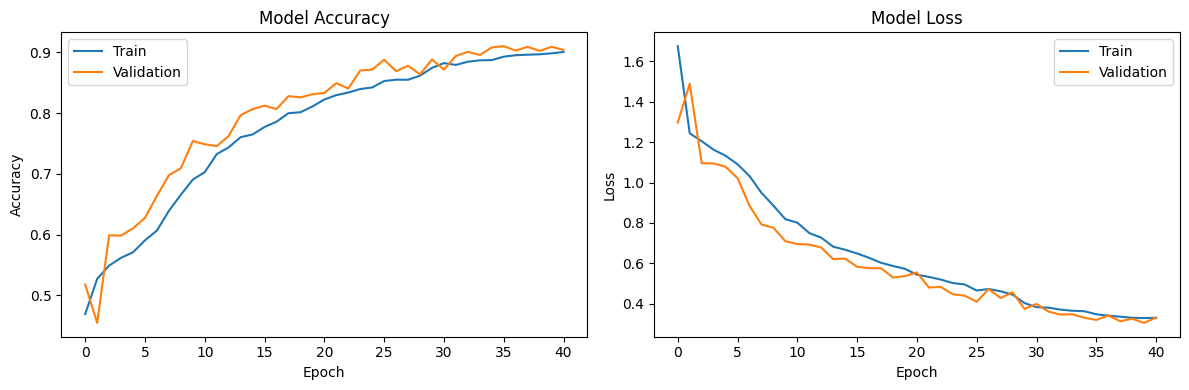


Evaluating model...
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8996 - loss: 0.3751


Test accuracy: 0.9005

Saving model...
Model saved.


In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import kerastuner as kt
from tqdm import tqdm

# Constants
TRAIN_PATH = '/content/drive/MyDrive/data/train'
TEST_PATH = '/content/drive/MyDrive/data/test'
VALID_PATH = '/content/drive/MyDrive/data/valid'
TARGET_SIZE = (128, 128)  # Try reducing size to (64, 64) for less memory usage
BATCH_SIZE = 32
NUM_CLASSES = 6

class_names = {
    0: 'DangerousDriving',
    1: 'Distracted',
    2: 'Drinking',
    3: 'SafeDriving',
    4: 'SleepyDriving',
    5: 'Yawn'
}

def read_annotation_file(file_path):
    """
    Read and parse annotation file into a DataFrame
    """
    annotations = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) < 2:
                continue
            image_name = parts[0]
            try:
                bbox = list(map(int, parts[1].split(',')))
                if len(bbox) != 5:
                    continue
                annotations.append([image_name] + bbox)
            except ValueError:
                continue
    return pd.DataFrame(
        annotations,
        columns=['image_name', 'x_min', 'y_min', 'x_max', 'y_max', 'class_id']
    )

def preprocess_image(image_path):
    """
    Load and preprocess a single image
    """
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return None  # or handle it however you'd prefer

    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return None

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, TARGET_SIZE)
    return image / 255.0  # Normalize pixel values

def prepare_dataset(annotations_df, base_path):
    """
    Prepare dataset by loading and preprocessing images and labels
    """
    images = []
    labels = []

    # Add progress bar to dataset preparation
    for _, row in tqdm(annotations_df.iterrows(), desc="Preparing dataset", total=len(annotations_df)):
        image_path = os.path.join(base_path, row['image_name'])
        if not os.path.exists(image_path):
            print(f"Skipping missing image: {image_path}")
            continue
        image = preprocess_image(image_path)
        if image is not None:
            images.append(image)
            labels.append(row['class_id'])

    # Convert lists to numpy arrays
    images = np.array(images)

    # One-hot encode labels
    encoder = OneHotEncoder(sparse_output=False)
    labels = np.array(labels).reshape(-1, 1)
    labels = encoder.fit_transform(labels)

    return images, labels

def build_model(hp):
    model = Sequential([
        tf.keras.layers.Input(shape=(128, 128, 3)),
        Conv2D(hp.Int('conv_1_filters', min_value=32, max_value=128, step=32), (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(hp.Int('conv_2_filters', min_value=64, max_value=128, step=32), (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(hp.Int('conv_3_filters', min_value=128, max_value=256, step=64), (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        GlobalAveragePooling2D(),
        Dense(hp.Int('dense_units', min_value=128, max_value=512, step=128), activation='relu'),
        Dropout(hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1)),
        Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def plot_training_history(history):
    """
    Plot training and validation metrics
    """
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.show()

def plot_predictions(model, test_images, test_labels, num_samples=16):
    indices = np.random.choice(len(test_images), num_samples, replace=False)
    sample_images = test_images[indices]
    sample_labels = test_labels[indices]
    predictions = model.predict(sample_images)

    fig, axes = plt.subplots(4, 4, figsize=(15, 15))
    for idx, ax in enumerate(axes.flat):
        ax.imshow(sample_images[idx])
        actual = class_names[np.argmax(sample_labels[idx])]
        predicted = class_names[np.argmax(predictions[idx])]
        ax.set_title(f'Actual: {actual}\nPredicted: {predicted}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Check GPU availability
def check_gpu():
    physical_devices = tf.config.list_physical_devices('GPU')
    if physical_devices:
        print(f"Using GPU: {physical_devices[0].name}")
        tf.config.experimental.set_memory_growth(physical_devices[0], True)  # Prevent GPU memory overflow
    else:
        print("No GPU found. Using CPU instead.")

check_gpu()  # Check and use GPU if available

print("Loading and preparing data...")

# Ensure the annotation file paths are correct
train_annotations = read_annotation_file(os.path.join(TRAIN_PATH, '_annotations.txt'))
valid_annotations = read_annotation_file(os.path.join(VALID_PATH, '_annotations.txt'))
test_annotations = read_annotation_file(os.path.join(TEST_PATH, '_annotations.txt'))

X_train, y_train = prepare_dataset(train_annotations, TRAIN_PATH)
X_val, y_val = prepare_dataset(valid_annotations, VALID_PATH)
X_test, y_test = prepare_dataset(test_annotations, TEST_PATH)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

# Hyperparameter tuning using Keras Tuner
print("\nStarting hyperparameter tuning...")
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='kerastuner_dir',
    project_name='driver_attention_tuning'
)

tuner.search(X_train, y_train, epochs=10, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))

best_model = tuner.get_best_models(num_models=1)[0]

print("\nTraining best model...")
history = best_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    verbose=2  # Use verbose=2 for progress bar during training
)

print("\nPlotting training history...")
plot_training_history(history)

print("\nEvaluating model...")
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

# Classification report
predictions = best_model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=list(class_names.values())))

print("\nVisualizing predictions...")
plot_predictions(best_model, X_test, y_test)

print("\nSaving best model...")
best_model.save('best_driver_attention_model.h5')
print("\nModel saved")


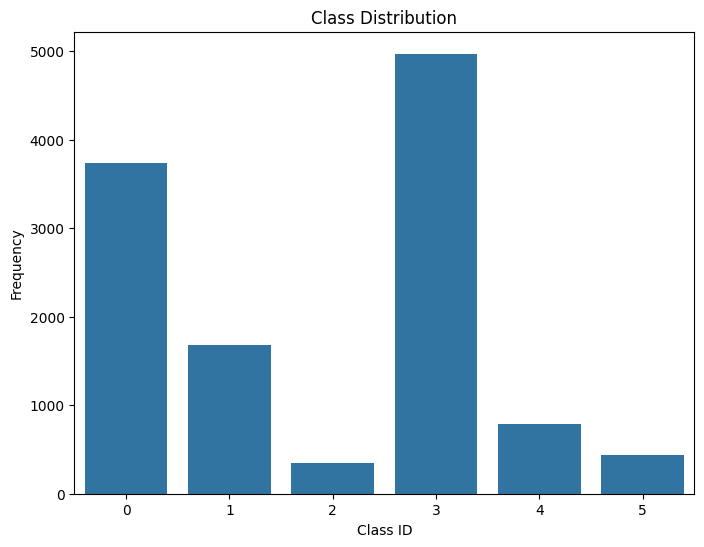

Processing images: 100%|██████████| 985/985 [11:53<00:00,  1.38it/s]


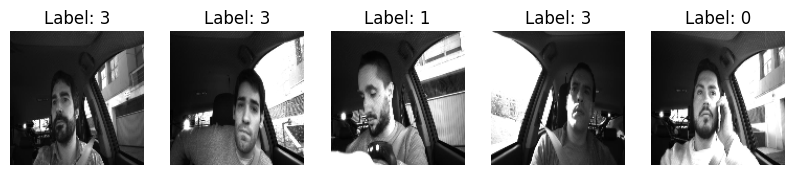

In [ ]:
# Import required libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2
from tqdm import tqdm

# Define constants
TRAIN_PATH = '/content/drive/MyDrive/data/train'
VALID_PATH = '/content/drive/MyDrive/data/valid'
TEST_PATH = '/content/drive/MyDrive/data/test'
TARGET_SIZE = (128, 128)
BATCH_SIZE = 32
NUM_CLASSES = 6

# Define class names for readability
class_names = {
    0: 'DangerousDriving',
    1: 'Distracted',
    2: 'Drinking',
    3: 'SafeDriving',
    4: 'SleepyDriving',
    5: 'Yawn'
}

# Helper function to read annotation files
def read_annotation_file(file_path):
    annotations = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) < 2:
                continue
            image_name = parts[0]
            try:
                bbox = list(map(int, parts[1].split(',')))
                if len(bbox) != 5:
                    continue
                annotations.append([image_name] + bbox)
            except ValueError:
                continue
    return pd.DataFrame(
        annotations,
        columns=['image_name', 'x_min', 'y_min', 'x_max', 'y_max', 'class_id']
    )

# EDA: Visualize class distribution
def plot_class_distribution(annotations_df):
    plt.figure(figsize=(8, 6))
    sns.countplot(x='class_id', data=annotations_df)
    plt.title('Class Distribution')
    plt.xlabel('Class ID')
    plt.ylabel('Frequency')
    plt.show()

# Preprocess and normalize images
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, TARGET_SIZE)
    return image / 255.0

# Prepare dataset by loading and processing images with a progress bar
def prepare_dataset(annotations_df, base_path):
    images = []
    labels = []

    # Use tqdm for progress bar
    for _, row in tqdm(annotations_df.iterrows(), total=len(annotations_df), desc="Processing images", colour="blue"):
        image_path = os.path.join(base_path, row['image_name'])
        image = preprocess_image(image_path)
        images.append(image)
        labels.append(row['class_id'])

    images = np.array(images).reshape(-1, TARGET_SIZE[0], TARGET_SIZE[1], 1)
    encoder = OneHotEncoder(sparse_output=False)
    labels = np.array(labels).reshape(-1, 1)
    labels = encoder.fit_transform(labels)

    return images, labels

# Display example images
def display_sample_images(images, labels, num_samples=5):
    indices = np.random.choice(len(images), num_samples, replace=False)
    plt.figure(figsize=(10, 5))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[idx].reshape(TARGET_SIZE), cmap='gray')
        plt.title(f"Label: {np.argmax(labels[idx])}")
        plt.axis('off')
    plt.show()

# Load and visualize the data
train_annotations = read_annotation_file(os.path.join(TRAIN_PATH, '_annotations.txt'))
valid_annotations = read_annotation_file(os.path.join(VALID_PATH, '_annotations.txt'))
test_annotations = read_annotation_file(os.path.join(TEST_PATH, '_annotations.txt'))

plot_class_distribution(train_annotations)
X_train, y_train = prepare_dataset(train_annotations, TRAIN_PATH)
X_val, y_val = prepare_dataset(valid_annotations, VALID_PATH)
X_test, y_test = prepare_dataset(test_annotations, TEST_PATH)
display_sample_images(X_train, y_train)

# Data Augmentation
data_augmentation = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True
)

# Define VGG-like model architecture
def create_vgg_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 1)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [ ]:
checkpoint = ModelCheckpoint('vgg_drowsiness_best_model.keras', save_best_only=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


374/374 ━━━━━━━━━━━━━━━━━━━━ 119s 253ms/step - accuracy: 0.4065 - loss: 1.4182 - val_accuracy: 0.4834 - val_loss: 1.2917 - learning_rate: 1.0000e-04
Epoch 2/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 74s 196ms/step - accuracy: 0.5029 - loss: 1.2226 - val_accuracy: 0.5536 - val_loss: 1.1699 - learning_rate: 1.0000e-04
Epoch 3/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 76s 203ms/step - accuracy: 0.6111 - loss: 1.0442 - val_accuracy: 0.7674 - val_loss: 0.7055 - learning_rate: 1.0000e-04
Epoch 4/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 76s 203ms/step - accuracy: 0.7609 - loss: 0.6623 - val_accuracy: 0.8392 - val_loss: 0.5081 - learning_rate: 1.0000e-04
Epoch 5/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 76s 202ms/step - accuracy: 0.8076 - loss: 0.5483 - val_accuracy: 0.8340 - val_loss: 0.4736 - learning_rate: 1.0000e-04
Epoch 6/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 76s 202ms/step - accuracy: 0.8323 - loss: 0.4650 - val_accuracy: 0.8725 - val_loss: 0.4216 - learning_rate: 1.0000e-04
Epoch 7/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 76s 203ms/step -

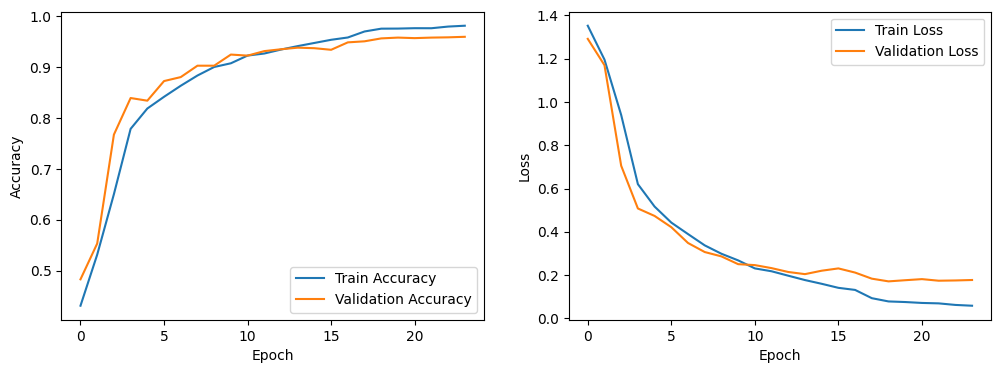

31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 232ms/step - accuracy: 0.9615 - loss: 0.1318
Test accuracy: 0.9574
Final model saved.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

# Callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('vgg_drowsiness_best_model.keras', save_best_only=True)

# Training the model
vgg_model = create_vgg_model()  # Make sure your model creation function is defined
history = vgg_model.fit(
    data_augmentation.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=30,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_training_history(history)

# Evaluate on test set
test_loss, test_accuracy = vgg_model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

# Save the trained model
vgg_model.save('driver_drowsiness_vgg_final_model.keras')
print("Final model saved.")


In [ ]:
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.1 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_tuner as kt

# Define constants
TRAIN_PATH = '/content/drive/MyDrive/data/train'
VALID_PATH = '/content/drive/MyDrive/data/valid'
TEST_PATH = '/content/drive/MyDrive/data/test'
TARGET_SIZE = (128, 128)
NUM_CLASSES = 6
BATCH_SIZE = 32

# Helper functions for preprocessing
import cv2

def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, TARGET_SIZE)
    return image / 255.0

def read_annotation_file(file_path):
    annotations = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) < 2:
                continue
            image_name = parts[0]
            try:
                bbox = list(map(int, parts[1].split(',')))
                if len(bbox) != 5:
                    continue
                annotations.append([image_name] + bbox)
            except ValueError:
                continue
    return pd.DataFrame(
        annotations,
        columns=['image_name', 'x_min', 'y_min', 'x_max', 'y_max', 'class_id']
    )

def prepare_dataset(annotations_df, base_path):
    images = []
    labels = []

    for _, row in annotations_df.iterrows():
        image_path = os.path.join(base_path, row['image_name'])
        image = preprocess_image(image_path)
        images.append(image)
        labels.append(row['class_id'])

    images = np.array(images).reshape(-1, TARGET_SIZE[0], TARGET_SIZE[1], 1)
    encoder = OneHotEncoder(sparse_output=False)
    labels = np.array(labels).reshape(-1, 1)
    labels = encoder.fit_transform(labels)

    return images, labels

# Load the data
train_annotations = read_annotation_file(os.path.join(TRAIN_PATH, '_annotations.txt'))
valid_annotations = read_annotation_file(os.path.join(VALID_PATH, '_annotations.txt'))
X_train, y_train = prepare_dataset(train_annotations, TRAIN_PATH)
X_val, y_val = prepare_dataset(valid_annotations, VALID_PATH)

# Define the model building function for Keras Tuner
def build_model(hp):
    model = tf.keras.Sequential()

    # Add convolutional layers with hyperparameters
    for i in range(hp.Int('conv_blocks', 2, 4)):
        model.add(
            Conv2D(
                filters=hp.Int(f'filters_{i}', min_value=32, max_value=128, step=32),
                kernel_size=(3, 3),
                activation='relu',
                padding='same',
                input_shape=(128, 128, 1) if i == 0 else None
            )
        )
        model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())

    # Add dense layers
    for i in range(hp.Int('dense_layers', 1, 2)):
        model.add(
            Dense(
                units=hp.Int(f'units_{i}', min_value=128, max_value=1024, step=128),
                activation='relu'
            )
        )
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', 0.2, 0.5, step=0.1)))

    # Output layer
    model.add(Dense(NUM_CLASSES, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Initialize the Keras Tuner

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='my_tuner',
    project_name='vgg_tuning'
)

# Perform the hyperparameter search
tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=BATCH_SIZE
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best number of convolutional blocks: {best_hps.get('conv_blocks')}")
print(f"Best filters: {[best_hps.get(f'filters_{i}') for i in range(best_hps.get('conv_blocks'))]}")
print(f"Best dense layers: {best_hps.get('dense_layers')}")
print(f"Best dense units: {[best_hps.get(f'units_{i}') for i in range(best_hps.get('dense_layers'))]}")
print(f"Best dropout rates: {[best_hps.get(f'dropout_{i}') for i in range(best_hps.get('dense_layers'))]}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=BATCH_SIZE
)


Trial 10 Complete [00h 01m 34s]
val_accuracy: 0.9157127737998962

Best val_accuracy So Far: 0.9287200570106506
Total elapsed time: 00h 25m 41s
Best number of convolutional blocks: 4
Best filters: [128, 96, 128, 96]
Best dense layers: 1
Best dense units: [512]
Best dropout rates: [0.30000000000000004]
Best learning rate: 0.001
Epoch 1/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.5047 - loss: 1.2235 - val_accuracy: 0.7856 - val_loss: 0.5746
Epoch 2/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.8047 - loss: 0.5474 - val_accuracy: 0.8267 - val_loss: 0.4686
Epoch 3/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.8567 - loss: 0.4003 - val_accuracy: 0.8658 - val_loss: 0.3774
Epoch 4/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.8962 - loss: 0.3051 - val_accuracy: 0.8866 - val_loss: 0.3566
Epoch 5/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.9078 - loss: 0.2678 - val_accuracy: 0.8996 - val_loss: 0.3290
Epoch 6/20
374/374 ━━━

In [ ]:
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.9207 - loss: 0.3836
Test Accuracy: 0.9177665114402771


In [ ]:
best_model.save('best_vgg_model.h5')


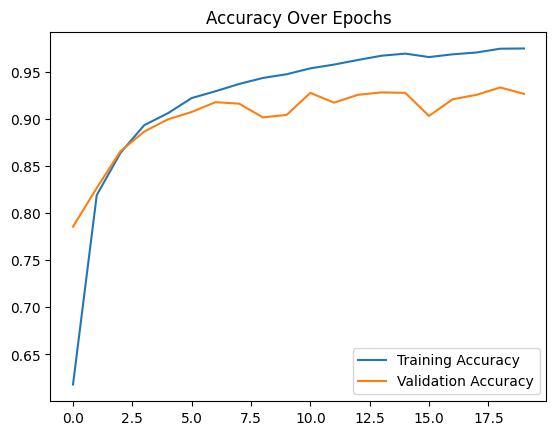

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()
